## Callin Switzer
10 Dec 2018
### Modified TLD script for running simulation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import math
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
from matplotlib.patches import Ellipse
from collections import OrderedDict
import sys
print(sys.version)
now = datetime.now()
print("last run on " + str(now))

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
last run on 2019-03-01 15:09:01.926768


In [2]:
from multiProcTraj import *

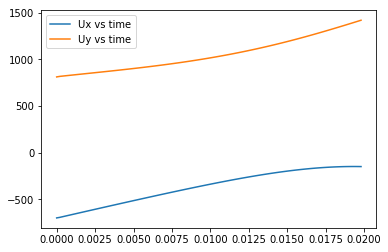

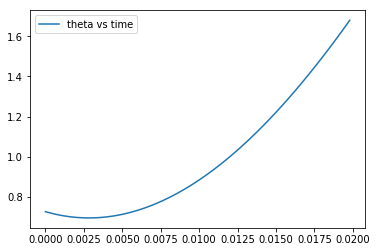

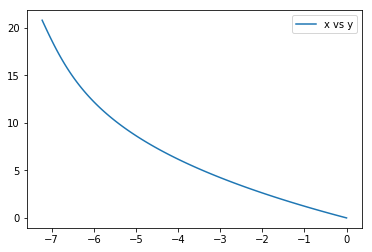

In [3]:
#This cell just checks to be sure we can run this puppy and graph results.
#  x,xd,y,yd,theta,thetad,phi,phid, F, alpha, tau0
state0 = [0.0, -697.247264, 0.0, 811.561430, 0.727497, -18.408509, 0.963598, -23.604126, 41869.951735, 6.189162, -42870.300882]  #initial conditions [x0 , v0  etc0 ]
ti = 0.0  # initial time
tf = 0.02  # final time
nstep = 100
step = (tf-ti)/nstep  # step
t = np.arange(ti, tf, step)
state = odeint(FlyTheBug, state0, t)
x = np.array(state[:,[0]])
xd = np.array(state[:,[1]])
y = np.array(state[:,[2]])
yd = np.array(state[:,[3]])
theta = np.array(state[:,[4]])
thetad = np.array(state[:,[5]])
phi = np.array(state[:,[6]])
phid = np.array(state[:,[7]])
#  And let's just plot it all
# sns.set()
plt.figure()
plt.plot(t,xd, label = 'Ux vs time')
plt.plot(t,yd, label = 'Uy vs time')
plt.legend()
plt.figure()
plt.plot(t,theta, label = 'theta vs time')
plt.legend()
plt.figure()
plt.plot(x,y, label = 'x vs y')
plt.legend()


In [4]:
# get final values
x[-1], xd[-1], y[-1], yd[-1], theta[-1], phi[-1] # this checks out

(array([-7.22712868]),
 array([-147.85561884]),
 array([20.78557499]),
 array([1418.05399817]),
 array([1.67982529]),
 array([1.97899914]))

In [5]:
# specify ranges
# x,xd,y,yd,
# theta,thetad,phi,phid, 
# F, alpha, tau0

np.random.seed(seed=123)

ranges = np.array([[0, 0], [-1500, 1500], [0, 0], [-1500, 1500],   
                   [0, 2*np.pi], [-25, 25], [0, 2*np.pi], [-25, 25], 
                  [0, 44300], [0, 2*np.pi], [-100000, 100000]])

tic = time.time()
t = np.linspace(0, 0.02, num = 100, endpoint = False) # time cut into 100 timesteps
nrun = 100  #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([nrun, nstep])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(nrun, ranges.shape[0]), )

# loop through all the runs
for i in range(0,nrun):
    # run ODE
    state = odeint(FlyTheBug, state0[i, :], t)
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
print('elapsed time = ',time.time()-tic)

elapsed time =  2.430015802383423


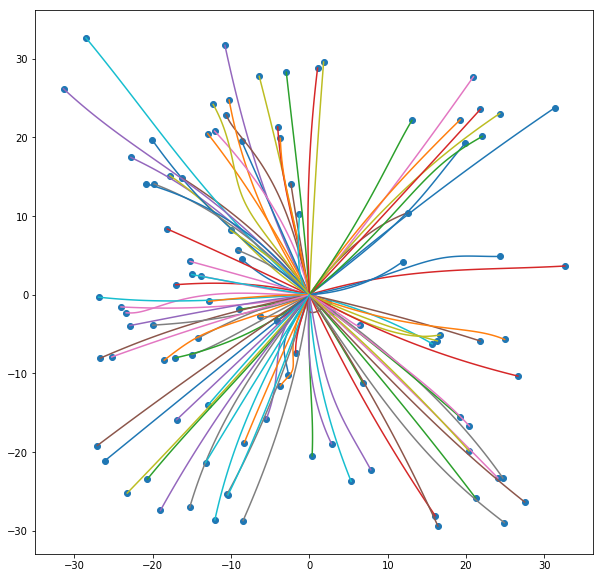

In [6]:
plt.figure(figsize = [10,10])
plt.axes().set_aspect('equal', 'datalim')
for i in range(0,nrun):
    plt.plot(x[i, :],y[i, :], label = 'trajectory x vs y')
    
    
plt.scatter(x[:,-1:][:,0], y[:,-1:][:,0])

In [ ]:
dfa = pd.DataFrame(state0, columns=["x","xd","y","yd","theta","thetad","phi","phid", "F", "alpha", "tau0"])

In [ ]:
df_final = pd.DataFrame(OrderedDict({"xf" : x[:,-1:][:,0], 
              "xdf" : xd[:,-1:][:,0], 
              "yf": y[:,-1:][:,0],
              "ydf" : yd[:,-1:][:,0], 
              "thetaf" : theta[:,-1:][:,0],
              "thetadf" : thetad[:,-1:][:,0], 
              "phif" : phi[:,-1:][:,0], 
              "phidf" : phid[:,-1:][:,0], 
             } ))
df_final.head()

In [ ]:
df_c = pd.concat([dfa.reset_index(drop=True), df_final], axis=1)
df_c.head()

In [ ]:
dataOutput

In [ ]:
#df_c.to_csv(os.path.join(dataOutput, "UpdatedCodeCheck.csv"), index= False)

In [ ]:
# read in Jorge's comparison
checkData = pd.read_csv(os.path.join(dataOutput, "UpdatedCodeCheck_output_all.csv"), )

In [ ]:
checkData.head()

In [ ]:
plt.figure(figsize = [10,10])
plt.axes().set_aspect('equal', 'datalim')

for i in range(0,nrun):
    plt.plot(x[i, :],y[i, :], alpha = 0.2)
    
plt.scatter(checkData.xf, checkData.yf, label = "Python")
plt.scatter(checkData.x_a, checkData.y_a, label = "Matlab")
plt.legend()


In [ ]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(checkData.xf - checkData.x_a, checkData.yf - checkData.y_a, s = 15, alpha = 0.4, c= "black")
plt.title("Error from matlab vs. python")


## Visualize moth at different timesteps
* See if moth is spinning
* See if abdomen is rotating too far

In [7]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    '''
    rho: radius
    phi: angle (in radians)
    '''
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def midpoint(p1, p2):
    return ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

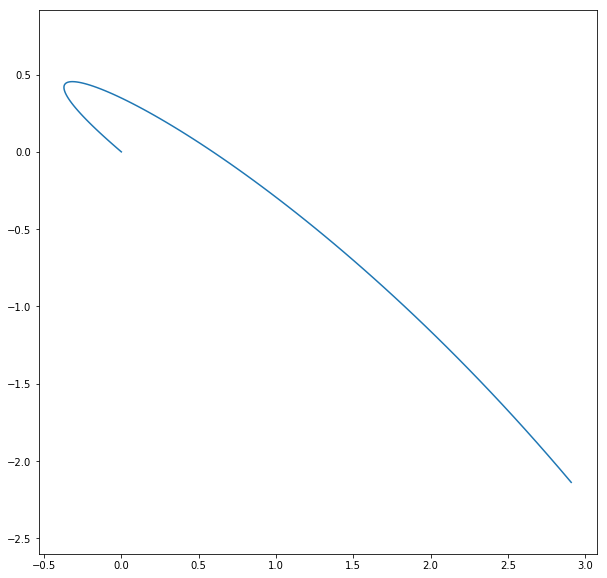

In [8]:
plt.figure(figsize = [10,10])
plt.axes().set_aspect('equal', 'datalim')
i =54
plt.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

In [9]:

bhead = 0.507
ahead = 0.908
bbutt  = 0.1295
abutt  = 1.174

# cgs  density of insect 
rho = 1 

# cgs density of air
rhoA = 0.00118

# cgs viscosity
muA = 0.000186 

# Length from the thorax-abdomen joint to the center of the 
# head-thorax mass in cm
L1 = 0.908 

# Length from the thorax-abdomen joint to the center of the 
# abdomen mass in cm
L2 = 1.747  

# Length from the thorax-abdomen joint to the aerodynamic force 
# vector in cm
L3 = 0.75 

# m1 is the mass of the head-thorax
m1 = rho*(4/3)*np.pi*(bhead**2)*ahead


# m2 is the mass of the abdomen 
# (petiole + gaster)
m2 = rho*(4/3)*np.pi*(bbutt**2)*abutt

print(m1 + m2)

1.0601357418678798


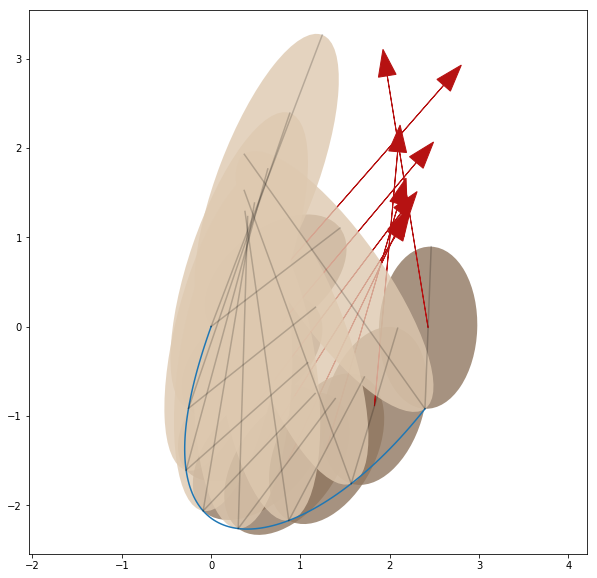

In [10]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory
fig, ax = plt.subplots( figsize = [10,10])
ax.set_aspect('equal', 'datalim')
i += 1
ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')


# add body positions:
for timestep in (np.linspace(0, 99, num = 8 )).astype(int):
    center = np.array([x[i, timestep], y[i, timestep]])
    head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
    abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))
    
    
    
    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

    ax.add_artist(el)
    ax.add_artist(el2)

    ax.plot(xx, yy, 'k', alpha = 0.2)
    #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)
    
    # plot force 
    forceAlpha = state0[i, 9]
    forceCenter = midpoint(center, head)
    forceMagnitude = state0[i, 8] / 15000 # scale 
    #ax.scatter(forceCenter[0], forceCenter[1], s= 30, c= 'r', alpha = 1)
    forceAngle = theta[i, timestep] + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    #ax.scatter(forceTip[0], forceTip[1], s= 30, c= 'r', alpha = 1)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")

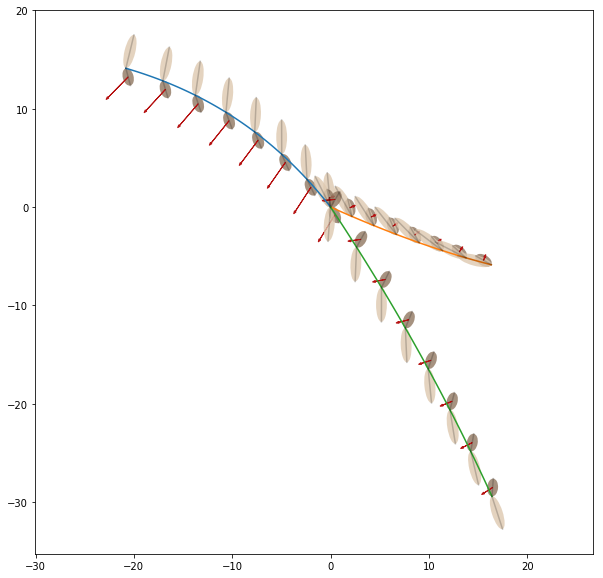

In [11]:
# plot moth with ellipses
# refref: what force would it take for the mother to counter-act gravity?

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory
fig, ax = plt.subplots( figsize = [10,10])
ax.set_aspect('equal', 'datalim')

for i in np.random.randint(0, high = nrun, size = 3):
    # plot trajectory
    ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

    # add body positions:
    for timestep in (np.linspace(0, 99, num = 8 )).astype(int):
        center = np.array([x[i, timestep], y[i, timestep]])
        head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
        abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))



        xx, yy = zip(*[center, head])
        xab,yab = zip(*[center, abTip])

        el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
        el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

        ax.add_artist(el)
        ax.add_artist(el2)

        ax.plot(xx, yy, 'k', alpha = 0.2)
        #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
        ax.plot(xab,yab, 'k', alpha = 0.2)
        #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)

        # plot force 
        forceAlpha = state0[i, 9]
        forceCenter = midpoint(center, head)
        forceMagnitude = state0[i, 8] / 15000 # scale 
        #ax.scatter(forceCenter[0], forceCenter[1], s= 30, c= 'r', alpha = 1)
        forceAngle = theta[i, timestep] + forceAlpha
        forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
        #ax.scatter(forceTip[0], forceTip[1], s= 30, c= 'r', alpha = 1)
        ax.arrow(x = forceCenter[0], y = forceCenter[1], 
                 dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
                head_width = 0.2, color = "#B61212")
        
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# scalebar = AnchoredSizeBar(ax.transData,
#                            980/1500, 'Force of gravity', 'lower right', 
#                            pad=0.1,
#                            color="#B61212",
#                            frameon=False,
#                            size_vertical=0.07, sep = 8)

# plt.gca().add_artist(scalebar)
# ax.add_artist(scalebar)

## Calculate Angle from torque

In [51]:
np.random.seed(seed=12035)
#  x,xd,y,yd,
# theta,thetad,phi,phid, 
# F, alpha, tau0
# ranges = np.array([[0, 0], [0.0001, 0.0001], [0, 0], [0.0001, 0.0001],   
#                    [np.pi/2, np.pi/2], [0, 0], [3*np.pi/2, 3*np.pi/2], [0, 0], 
#                   [0, 0], [0, 0], [0, -100000]])


ranges = np.array([[0, 0], [0.0001, 0.0001], [0, 0], [0.0001, 0.0001],   
                   [np.pi/2, np.pi/2], [0, 0], [3*np.pi/2, 3*np.pi/2], [0, 0], 
                  [0, 0], [0, 0], [-100, -100]])


tic = time.time()
nstep = 5000000
t = np.linspace(0, 7, num = nstep, endpoint = False) # time cut into 100 timesteps
nrun = 1 #number of trajectories.

# initialize the matrix of 0's
zeroMatrix = np.zeros([nrun, nstep])
x,      xd,    y,   yd, \
theta, thetad, phi, phid = [zeroMatrix.copy() for ii in 
                                range(len([ "x",     "xd",     "y", "yd", 
                                            "theta", "thetad", "phi", "phid"]))]

# generate random initial conditions for state 0
state0 = np.random.uniform(ranges[:, 0], ranges[:, 1], 
                           size=(nrun, ranges.shape[0]), )

# loop through all the runs
for i in range(0,nrun):
    # run ODE
    state = odeint(FlyTheBug, state0[i, :], t)
    x[i,:], xd[i,:] = state[:,0], state[:,1]
    y[i,:], yd[i, :] = state[:,2], state[:,3]
    theta[i,:], thetad[i, :] = state[:,4],state[:,5]
    phi[i,:], phid[i, :] = state[:, 6], state[:,7]
    print(i)
print('elapsed time = ',time.time()-tic)

0
elapsed time =  0.8098320960998535


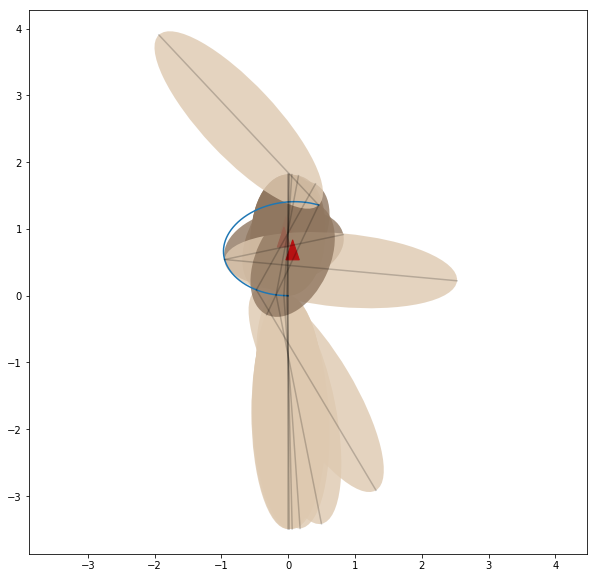

In [52]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory
fig, ax = plt.subplots( figsize = [10,10])
ax.set_aspect('equal', 'datalim')
i = 0
ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')


# add body positions:
for timestep in (np.linspace(0, nstep -1 , num = 8 )).astype(int):
    center = np.array([x[i, timestep], y[i, timestep]])
    head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
    abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))
    
    
    
    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

    ax.add_artist(el)
    ax.add_artist(el2)

    ax.plot(xx, yy, 'k', alpha = 0.2)
    #ax.scatter(xx, yy, s= 10, c = 'k', alpha = 0.2)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    #ax.scatter(xab,yab, s = 10, c = 'k', alpha = 0.2)
    
    # plot force 
    forceAlpha = state0[i, 9]
    forceCenter = midpoint(center, head)
    forceMagnitude = state0[i, 8] / 15000 # scale 
    #ax.scatter(forceCenter[0], forceCenter[1], s= 30, c= 'r', alpha = 1)
    forceAngle = theta[i, timestep] + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    #ax.scatter(forceTip[0], forceTip[1], s= 30, c= 'r', alpha = 1)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")

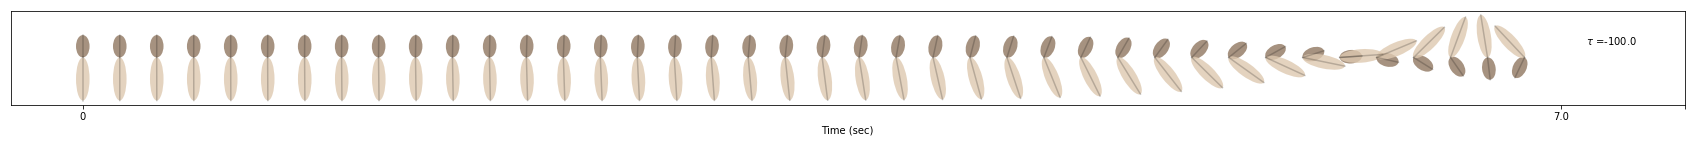

In [53]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory

if i >= (nrun - 1):
    i = 0

i += 1
# ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')

fig, ax = plt.subplots( figsize = [30,10])
ax.set_aspect('equal')

ctr1 = 0
for i in range(0, nrun):

    # add body positions:
    ctr = 0
    for timestep in (np.linspace(0, nstep - 1, num = 40)).astype(int):
        #center = np.array([x[i, timestep], y[i, timestep]])
        center = np.array([ctr,ctr1])
        ctr += 3
        head = center + np.array(pol2cart(thoraxLen, theta[i, timestep]))
        abTip = center + np.array(pol2cart(abLen, phi[i, timestep]))

        xx, yy = zip(*[center, head])
        xab,yab = zip(*[center, abTip])

        el = Ellipse(midpoint(center, head), width = thoraxLen, height = bodyWidth, facecolor='#907760', alpha=0.8, angle = math.degrees(theta[i, timestep]))
        el2 = Ellipse(midpoint(center, abTip), width = abLen, height = bodyWidth, facecolor='#DEC9B0', alpha=0.8, angle = math.degrees(phi[i, timestep]))

        ax.add_artist(el)
        ax.add_artist(el2)

        ax.plot(xx, yy, 'k', alpha = 0.2)
        ax.plot(xab,yab, 'k', alpha = 0.2)

    #plt.annotate("tau = " + str(np.round(state0[i,10])), center + (5, 1))
    plt.annotate(r'$\tau$ =' + str(np.round(state0[i,10], 5)), center + (5, 1))
    plt.xlabel("Time (sec)")
    plt.xticks([0, 120, 130],  [0, np.round(np.max(t)), ""])
    plt.yticks([])
  
    ctr1 -= 8
    
fig.savefig(os.path.join(figDir, "TauAndAngle.png"), dpi = 150) 
plt.show()


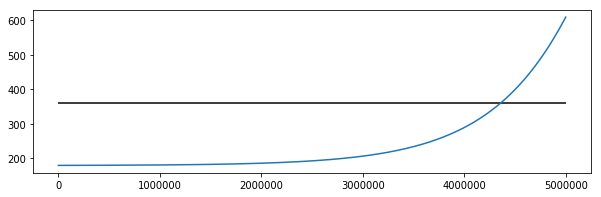

In [55]:
for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot([math.degrees(phi[i, jj] - theta[i, jj] ) for jj in range(len(phi[i,:]))])
    plt.hlines(360, xmin = 0, xmax = nstep)
    plt.show()

In [ ]:
for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot([math.degrees(theta[i, jj]) for jj in range(len(phi[i,:]))])
    plt.show()
  

In [ ]:

for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot([math.degrees(theta[i, jj]) for jj in range(len(phi[i,:]))])
    plt.show()
  

In [ ]:
# plot moth and force

timestep = 0
# theta = head angle
# phi = abdomen angle
thoraxLen = 0.908 * 2# cm
abLen = 1.747 *2 #cm
bodyWidth = 1.1


# plot trajectory

if i >= (nrun - 1):
    i = 0

i += 1
# ax.plot(x[i, :],y[i, :], label = 'trajectory x vs y')


#ax.set_aspect('equal')

ctr1 = 0
for i in range(0, nrun):
    fig, ax = plt.subplots( figsize = [10,3])
    plt.plot((phi[i, :] - theta[i, :]) - np.pi)
    plt.ylim(0, 10)
    plt.hlines(y = np.pi, xmin = 0, xmax = 10000)
    plt.show()
  
    

In [ ]:
print("tau = ", state0[i,10])
plt.show()
plt.plot((phi[i, :] - theta[i, :]) - np.pi)

plt.show()

In [ ]:
center